In [1]:
suppressPackageStartupMessages({
    library(dplyr)
    library(ggplot2)
    library(tictoc)
    library(RColorBrewer)
    devtools::load_all()
})

ℹ Loading cellAdmix


Two data files are needed for this tutorial, which can be downloaded at the following url:
https://nanostring.com/products/cosmx-spatial-molecular-imager/ffpe-dataset/nsclc-ffpe-dataset/ 
-"Processed Giotto Object"
-"Lung 5-1 Data files"


In [2]:
# load the molecule-level NSCLC spatial data
TRANSCRIPT_PATH <- './Lung5_Rep1/Lung5_Rep1-Flat_files_and_images/Lung5_Rep1_tx_file.csv'
tx_dat <- TRANSCRIPT_PATH %>% data.table::fread() %>% as.data.frame()

In [3]:
# load the giotto object to get cell type annotations
load('./giotto_dat/SMI_Giotto_Object.RData')

Important: to run the pipeline of KNN graph -> NMF -> CRF, we need to include columns
in the molecule-level dataframe called:
- 'cell' specifying the cell that the molecule belongs to
- 'x','y','z' specifying the coordinates of the transcript. Note, if no z coordinates exist for your data, you can set that column to a constant value.
- 'gene' specifying the gene that the molecule corresponds to
- 'mol_id' a character which is unique to a give molecule (can just be row index)

In [4]:
# Creating a new cell ID column to match the metadata in giotto object
tx_dat$cell <- paste0('c_1_',tx_dat$fov,'_',tx_dat$cell_ID)

In [5]:
cell_meta <- prepare_nsclc_metadata(gem)
df <- prepare_nscls_transcript_data(tx_dat, cell_meta)

In [6]:
# add annotation for regions we'll compare. It will be needed later for DE
cell_meta$regions_compare <- sapply(cell_meta$niche, switch, "tumor interior"="tumor", "stroma"="stroma", NA)

## Exploration plots

Let's look at the distribution of cell types and annotated regions over the tissue section

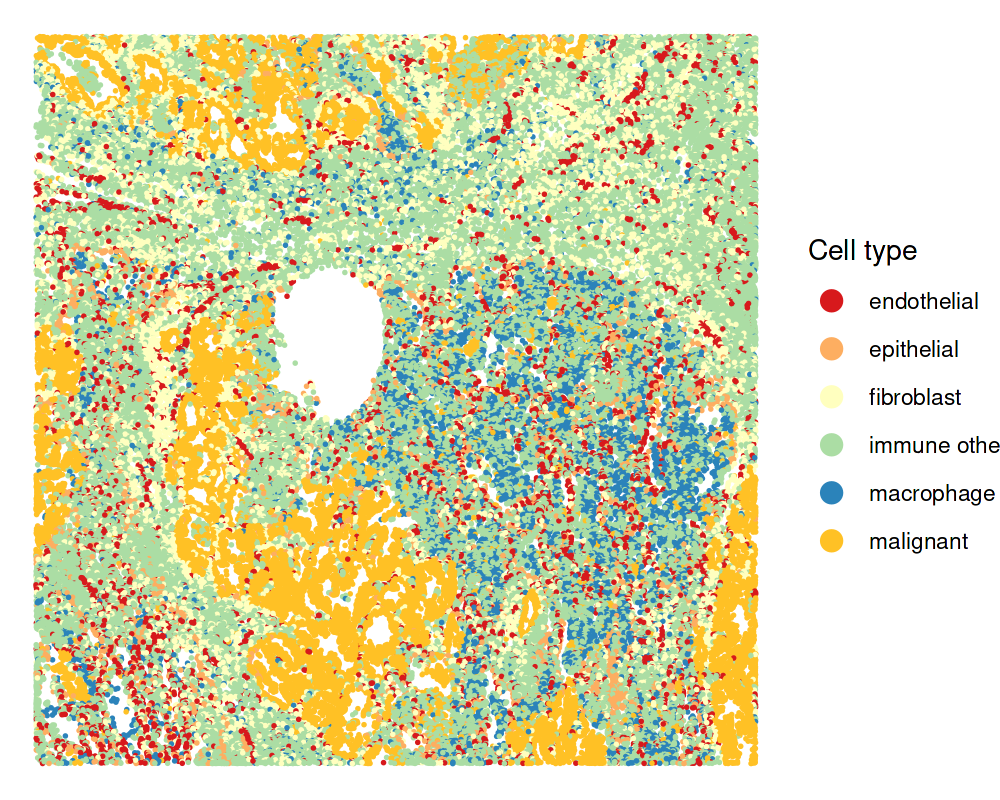

In [7]:
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 200)

# first show cells colored by cell type
ggplot(cell_meta,aes(x=sdimx,y=sdimy,color=cell_type_coarse)) +
  geom_point(size=.001) +
  scale_colour_manual(values = c(brewer.pal(5, 'Spectral'), 'goldenrod1')) +
  guides(colour = guide_legend(override.aes = list(size=3))) +
  labs(color='Cell type') +
  theme_void() +
  theme(legend.text=element_text(size=8),
        legend.title=element_text(size=10))

Next, show cells colored by region assignment

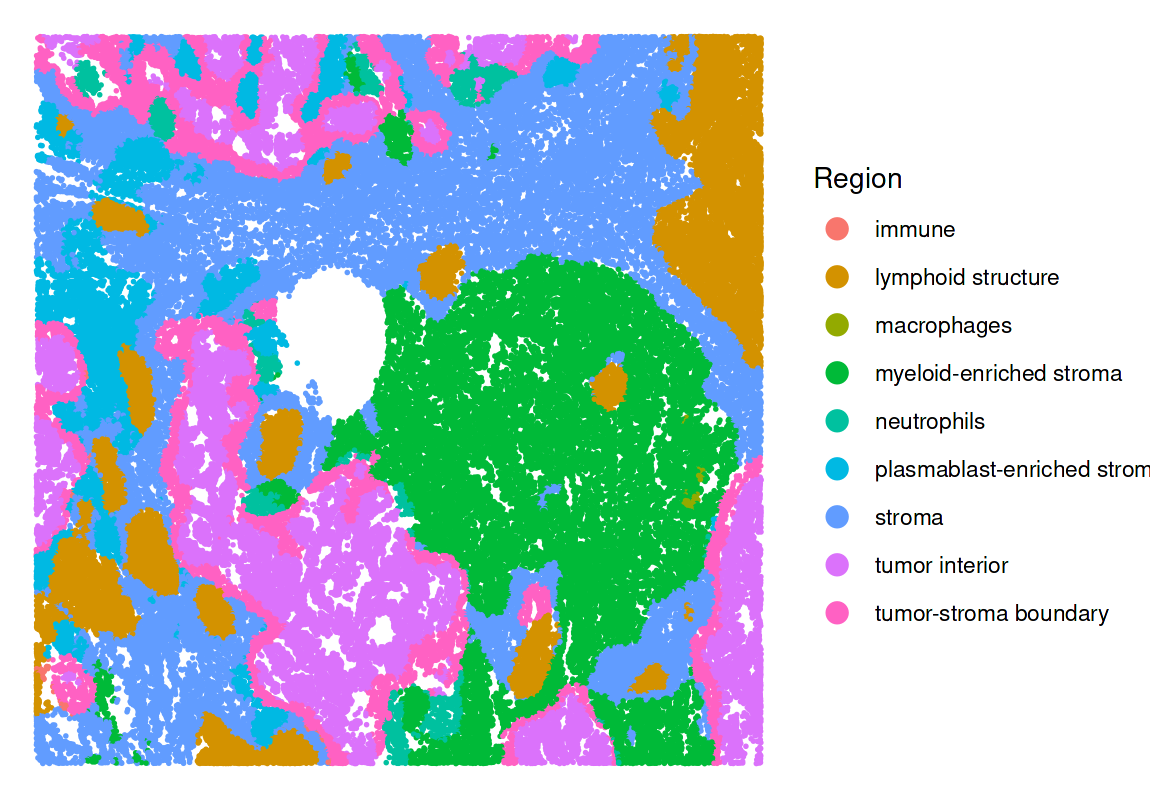

In [8]:
options(repr.plot.width = 5.75, repr.plot.height = 4, repr.plot.res = 200)

ggplot(cell_meta,aes(x=sdimx,y=sdimy,color=niche)) +
  geom_point(size=.001) +
  guides(colour = guide_legend(override.aes = list(size=3))) +
  labs(color='Region') +
  theme_void() +
  theme(legend.text=element_text(size=8),
        legend.title=element_text(size=10))

## Malignant markers in fibroblasts

Next, we'll illustrate how fibroblasts in the tumor interior region appear to overexpress malignant cell markers relative to fibroblasts in the stroma. This effect will be apparent when running differential expression between fibroblasts in the tumor interior versus the stroma regions, as malignant markers will appear to be upregulated for fibroblasts in the tumor interior.

In [9]:
dat_orig <- transcripts_to_count_matrix(df)

In [10]:
# reduce data to just the fibroblast cells in the tested regions
cells_keep <- cell_meta %>% filter(celltype=='fibroblast', !is.na(regions_compare)) %>% .$cell
meta_orig <- cell_meta[cells_keep,]
dat_orig <- dat_orig[,cells_keep]

print(dim(dat_orig))
print(dat_orig[1:5,1:5])

[1]  980 7031
      cell
gene   c_1_1_18 c_1_1_25 c_1_1_26 c_1_1_36 c_1_1_58
  AATK        0        0        0        0        0
  ABL1        0        0        0        0        0
  ABL2        0        0        0        0        0
  ACE         0        0        0        0        0
  ACE2        0        0        0        0        0


In [11]:
## run de for fibroblasts between tumor and stroma
regions_compare <- meta_orig %>% {setNames(.$regions_compare, rownames(.))}
de_out_orig <- run_pagoda_de(dat_orig, groups=regions_compare)$tumor

Warning message:
“Removed 976 rows containing missing values (`geom_text_repel()`).”


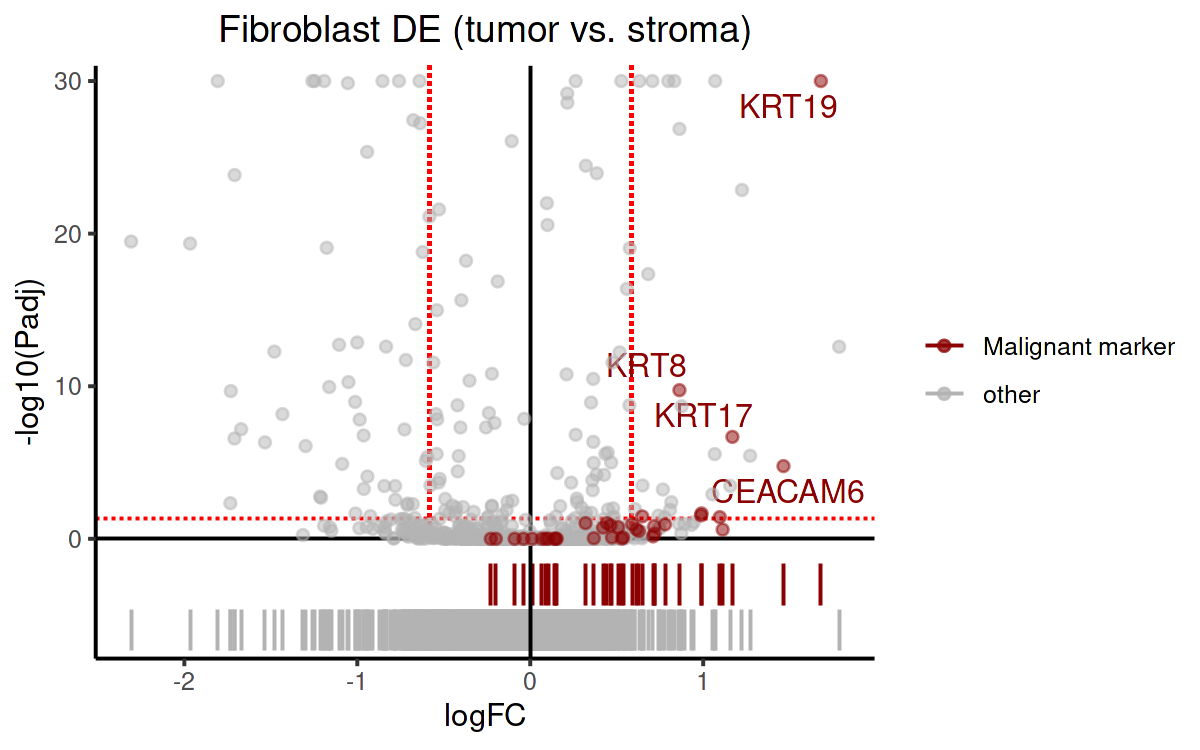

In [12]:
options(repr.plot.width = 6, repr.plot.height = 3.75, repr.plot.res = 200)

tumor_marker_genes <- c(
    "KRT19", "KRT8", "KRT18", "TACSTD2", "CEACAM6", "CDH1", "EPCAM",
    "CLDN4", "SFN", "PHLDA2", "DDR1", "AGR2", "KRT6A", "KRT17",
    "CD24", "KRT5", "AQP3", "SLC2A1", "KRT7", "COL17A1", "FASN",
    "KRT15", "ITGA2", "ERBB3", "S100A2", "SPINK1", "ITGB4", "PIGR",
    "SOX2", "ITGA3", "CYSTM1", "NTRK2", "MAPK13", "CCND1", "HDAC1", "EGFR"
)

genes_to_label <- c('KRT19','KRT8','KRT17','CEACAM6')

de_volcano_plot(de_out_orig, tumor_marker_genes, genes_to_label=genes_to_label) +
    ggtitle('Fibroblast DE (tumor vs. stroma)')

In the above plot we can see that malignant marker genes rise to the top of the DE genes in fibroblast cells. Specifically, they appear upregulated for fibroblasts in the tumor relative to stroma regions. The malignant marker genes were identified in a separate scRNA-seq dataset.

## Removing admixture

Next, we'll apply our correction method to identify and remove admixture genes from the fibroblast cells.

In [13]:
# subset to only fibroblasts inside the tumor interior niche to help pull out the contamination signal
ct <- 'fibroblast'
df_subs <- df[df$celltype==ct,]

match_ndx <- match(df_subs$cell,cell_meta$cell)
df_subs$niche <- cell_meta$niche[match_ndx]
df_tumor <- df_subs[df_subs$niche=='tumor interior',]

# removing unneeded columns from the df
df_tumor <- df_tumor[,c('cell','gene','niche','mol_id','x','y','z')]

print(head(df_tumor))

           cell     gene          niche mol_id        x        y   z
826495 c_1_2_76     MMP1 tumor interior 493361 2399.334 28573.55 7.2
826496 c_1_2_76 HLA-DQB1 tumor interior 493362 2397.822 28572.18 2.4
826497 c_1_2_76   COL1A2 tumor interior 493363 2398.117 28570.65 2.4
826498 c_1_2_76     C1QB tumor interior 493364 2397.170 28573.14 2.4
826499 c_1_2_76     RGS2 tumor interior 493365 2402.366 28561.64 2.4
826500 c_1_2_76     CD68 tumor interior 493366 2397.301 28573.15 2.4


Now, we'll compute the neighborhood composition vectors (knn for each molecule) and run NMF on this

In [14]:
# compute the molecule NCV matrix
X <- get_knn_counts(df_tumor, k=20, ncores = 20) %>% as.matrix()

print(dim(X))
print(X[1:5,1:5])

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.8 GiB”


[1] 251971    980
       AATK ABL1 ABL2 ACE ACE2
127120    0    0    0   0    0
127121    0    0    0   0    0
127122    0    0    0   0    0
127123    0    0    0   0    0
127124    0    0    0   0    0


In [15]:
res <- run_weighted_nmf(X, k=5, n.downsample=5000)
expr <- res@fit@H %>% {. / rowSums(.)} %>% t() %>% magrittr::set_colnames(1:ncol(.))

NMF algorithm: 'ls-nmf'

Multiple runs: 30

Mode: parallel (2/96 core(s))



Runs: |==================================================| 100%
System time:
    user   system  elapsed 
3522.165 1387.488 5022.332 


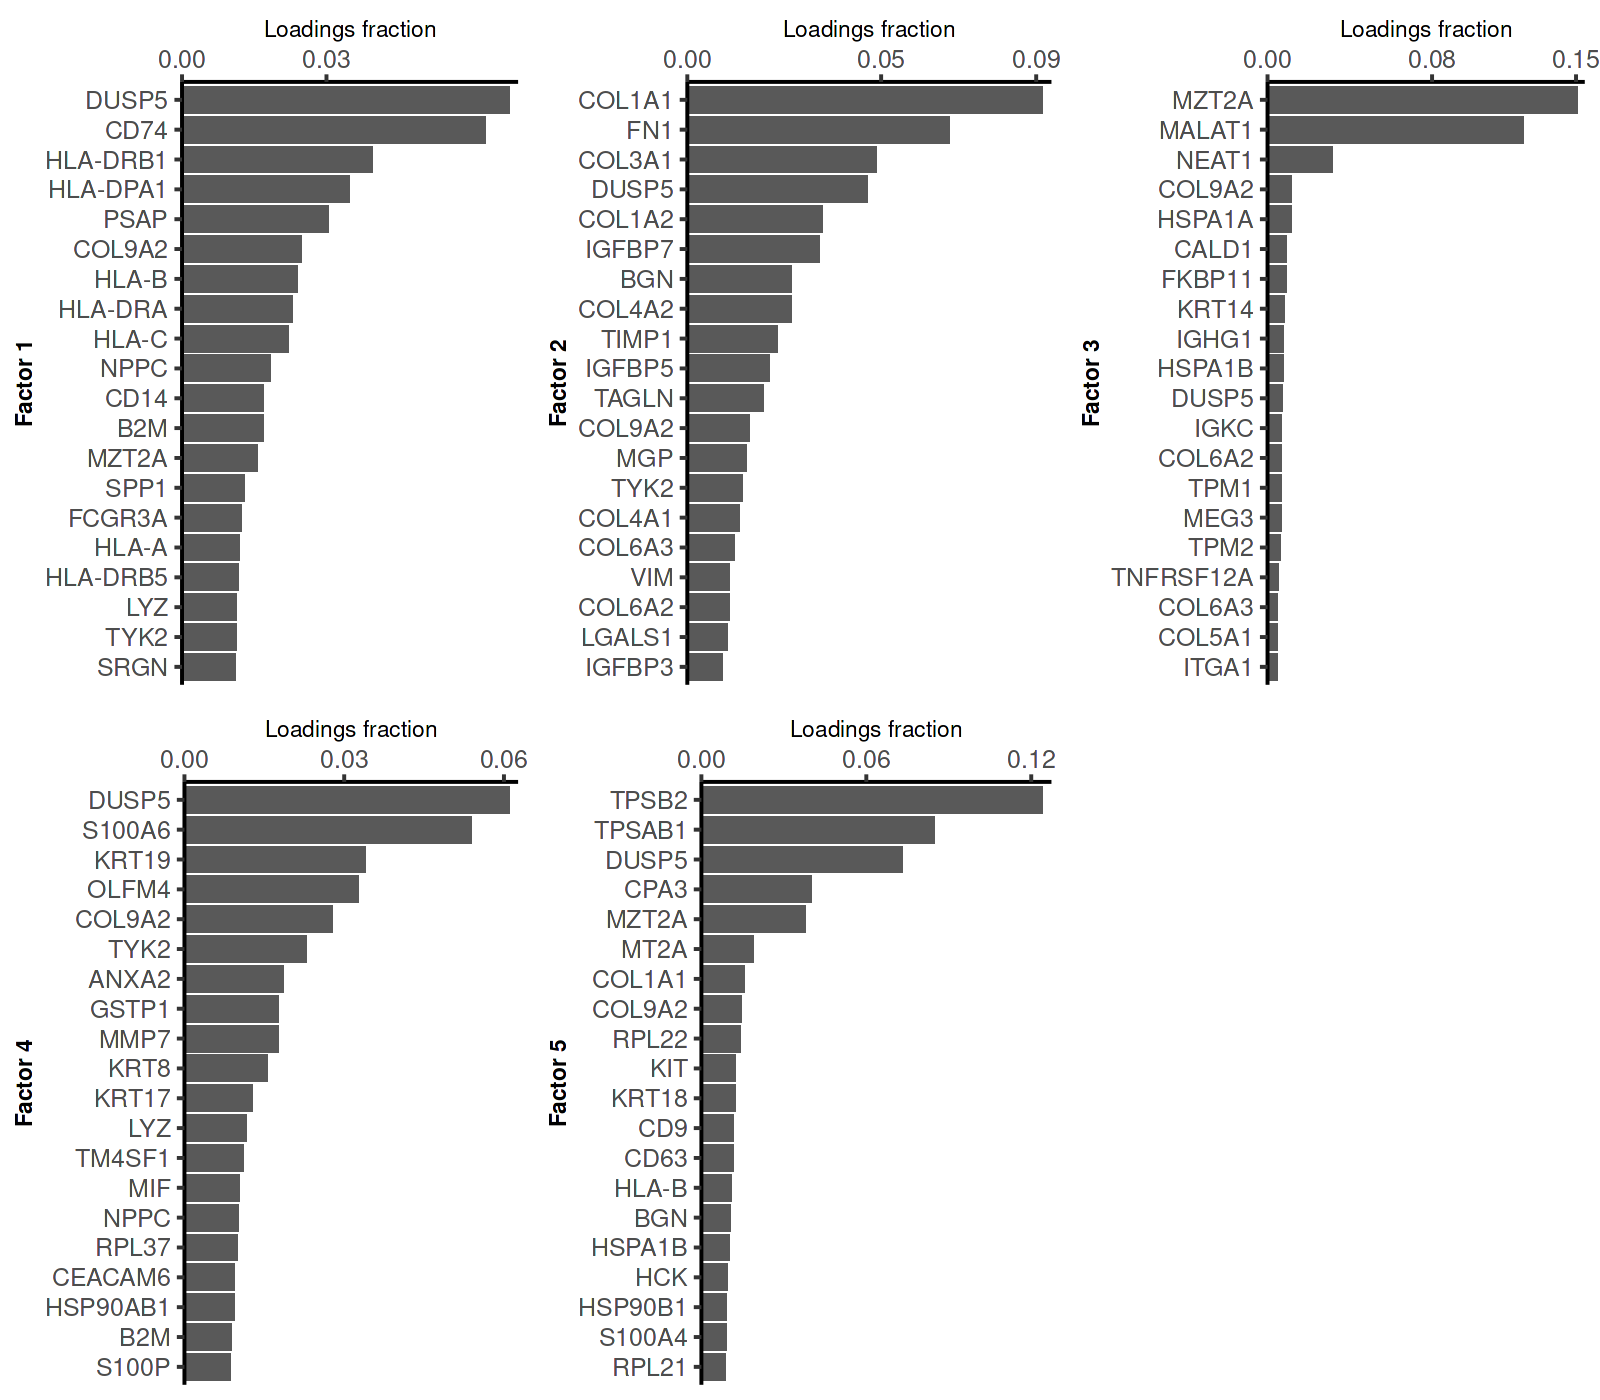

In [20]:
# Plot some loadings for the factors
options(repr.plot.width = 8, repr.plot.height = 7, repr.plot.res = 200)

lapply(1:ncol(expr), function(i) plot_nmf_loading(expr[,i], factor.name=paste('Factor', i))) %>% 
    cowplot::plot_grid(plotlist=., nrow=2,align = 'h')

Here, factor 1 appears to represent admixture from malignant cells since several of the top loading genes are KRT19, KRT8, and KRT17, which are specific malignant markers. Note that the dataset downsampling step may cause these results to look slightly different from yours, so you will need to identify which factor corresponds to the malignant cell admixture and modify the following cell.

In [21]:
malignant_admix_factor <- 4

Next, we will run CRF to assign each molecule to one of these factors. Then, we can remove the molecules coming from contaminating cell types.

In [22]:
# run crf
df_fib_crf <- run_crf_per_cell(df_subs, expr, ncores=30)

# this appended a column 'factor' indicating which factor each molecule has been assigned to
head(df_fib_crf, 3)

,fov,cell_ID,x,y,x_local_px,y_local_px,z,gene,CellComp,cell,celltype,mol_id,niche,id,factor
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
221062,1,1009,765.8845,28292.61,1066.025,1964.475,8.8,THBS1,Nuclear,c_1_1_1009,fibroblast,221062,tumor-stroma boundary,221062,3
221063,1,1009,767.7115,28289.52,1076.175,1947.325,8.8,FAS,Nuclear,c_1_1_1009,fibroblast,221063,tumor-stroma boundary,221063,3
221064,1,1009,768.6910,28293.16,1081.617,1967.533,2.4,HLA-A,Nuclear,c_1_1_1009,fibroblast,221064,tumor-stroma boundary,221064,2


In [23]:
# now, remove the molecules assigned to the admixture factor
df_fib_cln <- filter(df_fib_crf, !(factor %in% malignant_admix_factor))

print(paste0('Number of molecules originally: ', nrow(df_fib_crf)))
print(paste0('Number of molecules after cleaning: ', nrow(df_fib_cln)))

[1] "Number of molecules originally: 3940608"
[1] "Number of molecules after cleaning: 3755840"


Next, we'll show that contamniating malignant marker gene expression is reduced in fibroblasts, while fibroblast markers remain unchanged post cleaning.

In [24]:
# compute a clean counts matrix from molecule level data
dat_cln <- df_fib_cln %>% transcripts_to_count_matrix() %>% .[,rownames(meta_orig)]

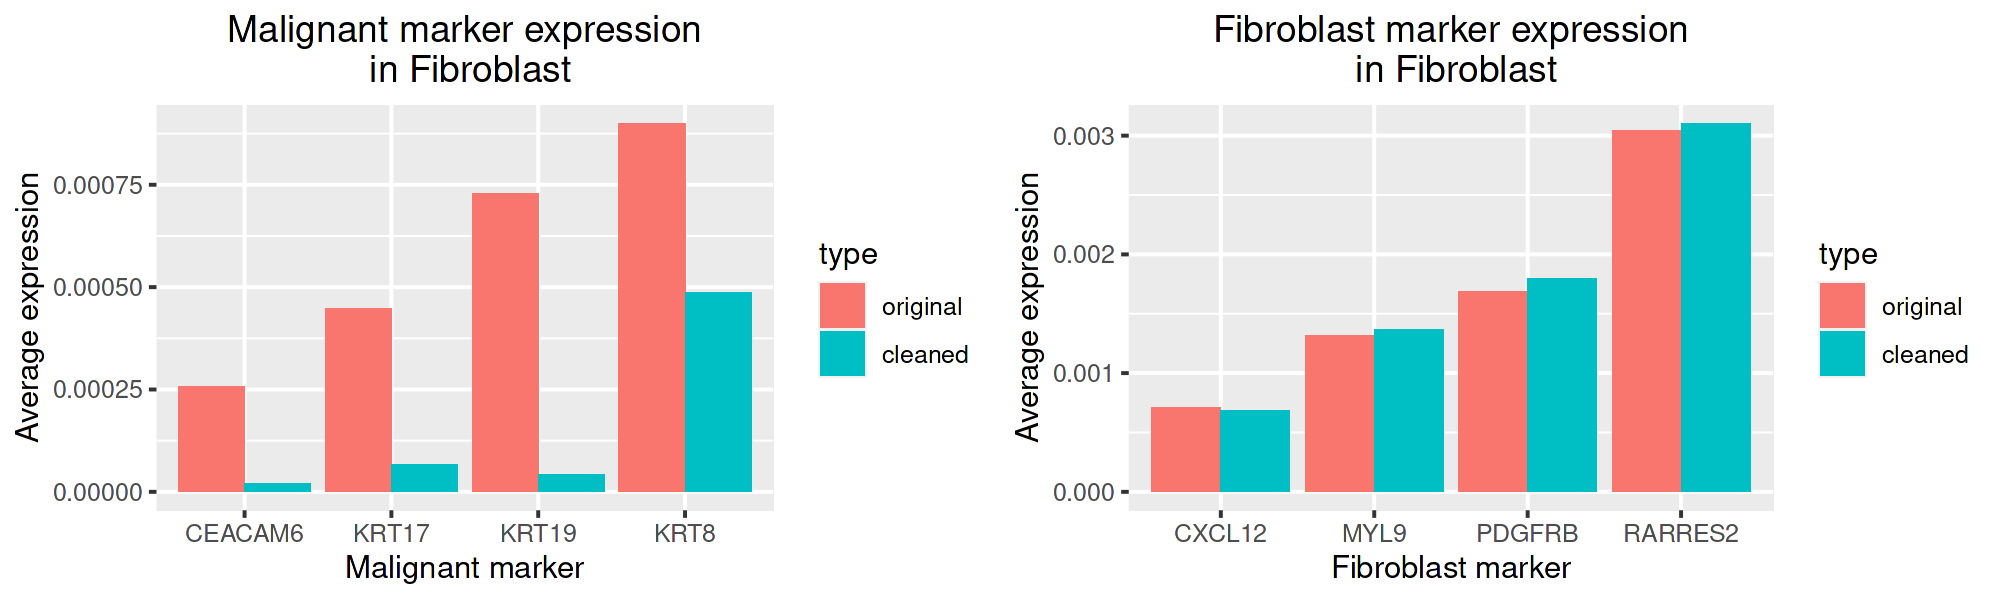

In [25]:
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 200)

plot_expression_comparison(
    dat_orig, dat_cln, 
    markers_native=c('MYL9','CXCL12','PDGFRB','RARRES2'), 
    markers_admix=c('KRT19','KRT8','KRT17','CEACAM6'), 
    admixture_type='Malignant', native_type='Fibroblast'
)

Now, we show how this cleaning process mitigates the degree to which admixture dominates the DE results.

In [26]:
de_out_cln <- run_pagoda_de(dat_cln, groups=regions_compare)$tumor

Warning message:
“Removed 976 rows containing missing values (`geom_text_repel()`).”


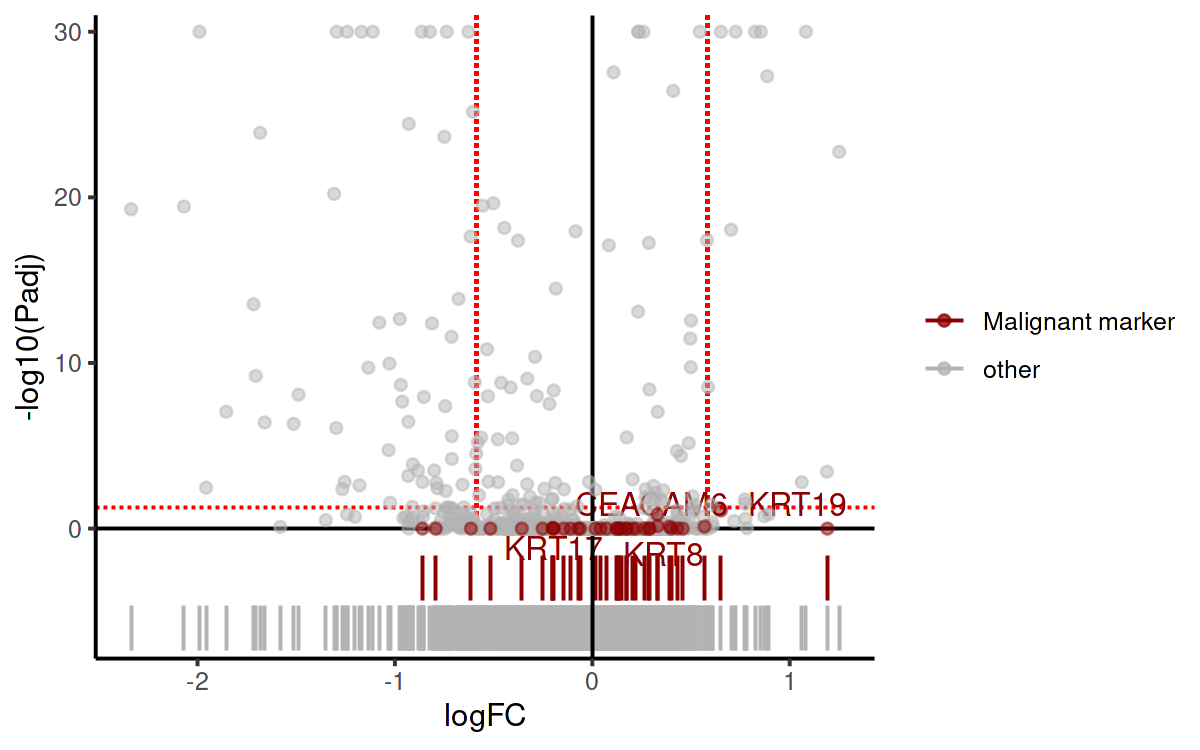

In [27]:
options(repr.plot.width = 6, repr.plot.height = 3.75, repr.plot.res = 200)
de_volcano_plot(de_out_cln, tumor_marker_genes, genes_to_label=genes_to_label)

Warning message:
“Removed 976 rows containing missing values (`geom_text_repel()`).”


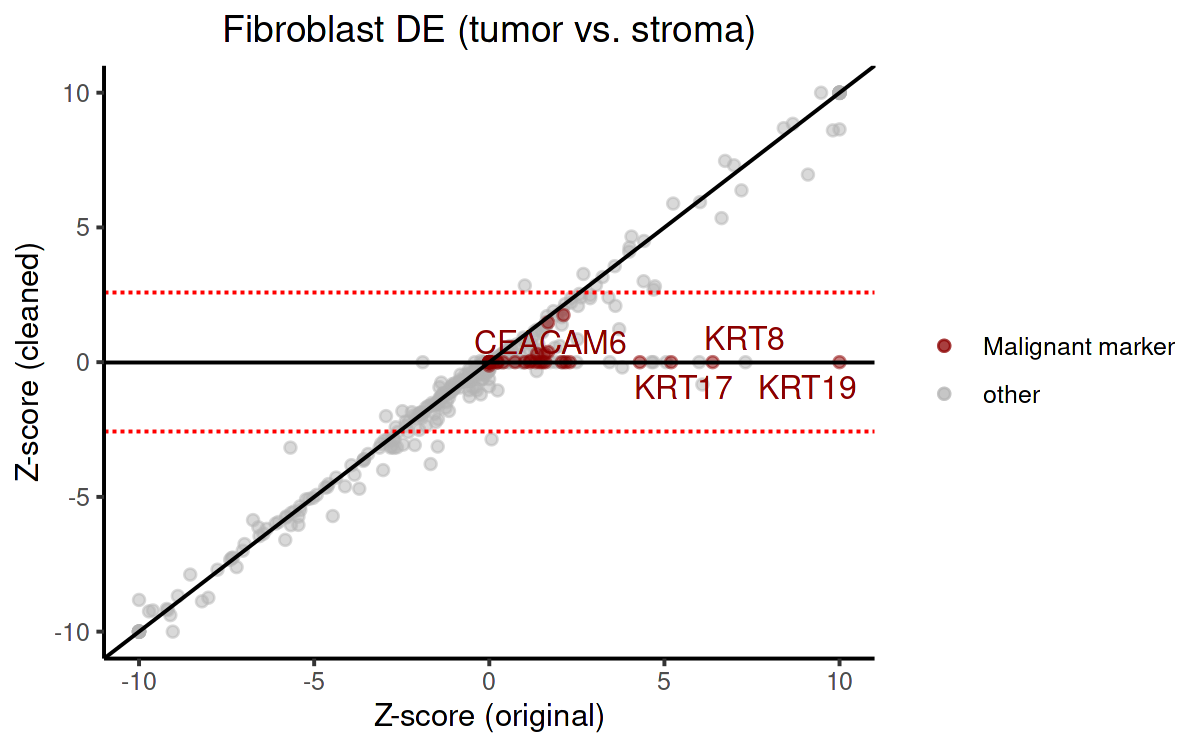

In [28]:
plot_de_comparison(
    de_out_orig, de_out_cln,
    genes_to_label=genes_to_label,
    tumor_marker_genes=tumor_marker_genes
) + ggtitle('Fibroblast DE (tumor vs. stroma)')

We see that the fibroblast DE Z-scores for malignant cell markers are no longer significant after applying the cleaning procedure.